# Identify specific populations and expand these masks 


By employing the CosMx data, we sought to identify gamma delta (γδ) T cells, a rare immune cell subset that is otherwise difficult to detect through clustering and phenotyping of segmented cells 

To achieve this, we applied GRIDGEN’s convolutional approach to identify putative regions enriched for γδ T cell transcripts. Specifically, we identified areas where TRGC and TRDC transcripts, encoding for the T cell receptor (TCR) constant regions of γδ T cells, were within 5.5 µm of each other, with contours highlighting these regions. Beyond the presence of TRGC and TRDC transcripts in a confined area, specific criteria were applied, including thresholds on transcript counts, contour size, and transcript combinations, specifically requiring the sum of TRGC and TRDC counts to be higher than the sum of TRAC and TRBC (encoding for the TCR of γδ T cells), with at least one TRGC and one TRDC . 

The resulting regions represent putative γδ T cell areas that can be subjected to further analysis. 

In [3]:
%load_ext autoreload

import os 
import sys
import time
import logging
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json

from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from PIL import Image, ImageDraw
import json
import math
import matplotlib.patches as mpatches


sys.path.append(os.path.dirname(os.getcwd()))
from src import get_arrays as ga
from src import contours 
from src import masks
from src.mask_properties import GetMasksProperties

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


define looger -- important to save info of the runs 

In [4]:
# define the logger :  can be None, and is set to INFO
# Custom logger setup
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

define files

In [7]:
cosmx_path_s3 =  '../../cosmx_data/S3/S3/20230628_151317_S3/AnalysisResults/yxyz3r7ufm'

folder_names_s3 = [folder_name for folder_name in os.listdir(cosmx_path_s3) if
                os.path.isdir(os.path.join(cosmx_path_s3, folder_name))]


target_files_s3 = [
    os.path.join(cosmx_path_s3, folder, file)
    for folder in os.listdir(cosmx_path_s3)
    if os.path.isdir(os.path.join(cosmx_path_s3, folder))
    for file in os.listdir(os.path.join(cosmx_path_s3, folder))
    if '__target_call_coord.csv' in file
]

files_cosmx = natsorted(target_files_s3)
len(files_cosmx)

dapi_folder = '/home/martinha/PycharmProjects/phd/spatial_transcriptomics/cosmx_data/S3/S3/20230628_151317_S3/CellStatsDir/Morphology2D/'
annotation_cellpose = '/home/martinha/PycharmProjects/phd/spatial_transcriptomics/cosmx_data/S3/Slide4_S3_CosMx_CellPose_All_annotated.csv'


annotation_df = pd.read_csv(annotation_cellpose)
print(annotation_df['Final_label'].value_counts())
print(len(annotation_df))

Final_label
Epithelial cells     20558
T cells               9436
Myeloid cells         6688
Fibroblasts           6133
Other cells           4988
Plasma cells          1656
Endothelial cells     1508
Name: count, dtype: int64
50967


# 2. Define GD

This intends to, based on defined genes, find γδ T cells.

We need to define: 

1. Parameters for γδ contours
    * Genes to consider
    * density
    * minimum area
    * kernel size
    
    this will define for an overlapping area with **kernel size** a minimum number of **density** **genes of interest**. The contiguous area of the contour will have at least **minimum area**. 
 
2. You may also need to define extra parameters to filter out wrong contours   

Define arrays for an example FOV

In [4]:
target_gd = ['TRGC1/TRGC2', 'TRDC']
target_ab = ['TRBC1/TRBC2', 'TRAC']

target_cd8 = ['CD8A','CD8B', 'TRBC1/TRBC2', 'TRAC']
target_cd4 = ['CD4']

target_tum = ['EPCAM', 'CEACAM6', 'CLDN4', 'CDH1', 'RNF43', 'SPINK1', 'SOX9', 'CD24', 'KRT19', 'AREG',
              'REG1A', 'AGR2', 'PLAC8', 'CALB1', 'S100P', 'ITGA6', 'DMBT1', 'DUSP4',
              'KRT8', 'S100A6', 'RPL37', 'RPL32', 'KRT18', 'OLFM4',
              'PRSS2', 'CD55', 'EPHB4', 'ADGRL1', 'KRT17', 'ITGB8', 'ADGRE5', 'GDF15', 'IL27RA', 'AZGP1'
              ]  # cadherin 'PIGR',  'LYZ','SERPINA1'

In [5]:
fov = 'FOV007'
file_csv = [file for file in files_cosmx if fov in file][0]  
    
df_total = pd.read_csv(file_csv)
df_total = df_total.rename(columns={'x': 'X', 'y': 'Y'})
df_total = df_total[~df_total['target'].str.contains('System|egative')]

n_genes = len(df_total['target'].unique())
height = int(max(df_total['X'])) + 1
width = int(max(df_total['Y'])) + 1

print(f'n genes: {n_genes}')
print(f'shape: {height}, {width}')
print(f'n hits {len(df_total)}')

target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)

# creating subsets 
df_subset_gd, array_subset_gd, target_indices_subset_gd = ga.get_subset_arrays(df_total, array_total,
                                                                                   target_dict_total,
                                                                                   target_list=target_gd,
                                                                           target_col='target')

df_subset_ab, array_subset_ab, target_indices_subset_ab = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=target_ab,
                                                                                       target_col='target')
    
    
df_subset_g, array_subset_g, target_indices_subset_g = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRGC1/TRGC2'],
                                                                                       target_col='target')
    
df_subset_d, array_subset_d, target_indices_subset_d = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=['TRDC'],
                                                                                       target_col='target')


df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                         target_list=target_tum, target_col = 'target')


df_subset_cd8, array_subset_cd8, target_indices_subset_cd8 = ga.get_subset_arrays(df_total, array_total,
                                                                                      target_dict_total,
                                                                                      target_list=target_cd8,
                                                                                      target_col='target')
                                                                               

df_subset_TRAC_gene, array_subset_TRAC_gene, target_indices_subset_TRAC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRAC'],
                                                                                      target_col='target')

df_subset_TRBC_gene, array_subset_TRBC_gene, target_indices_subset_TRBC_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['TRBC1/TRBC2'],
                                                                                      target_col='target')


df_subset_cd8_gene, array_subset_cd8_gene, target_indices_subset_cd8_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD8A', 'CD8B'],
                                                                                      target_col='target')

df_subset_cd4_gene, array_subset_cd4_gene, target_indices_subset_cd4_gene = ga.get_subset_arrays(df_total, 
                                                                                                 array_total,
                                                                                      target_dict_total,
                                                                                      target_list= ['CD4'],
                                                                                      target_col='target')



n genes: 999
shape: 4246, 4245
n hits 2838781


T cells are usually between 5-10 um diameter, in CosMx this will be between 43 px and 85 px. 
We will find regions possible with γδ using the convolution approach.

In [6]:
density_th_gd = 2
min_area_th_gd = 5  # 40
kernel_size_gd = 45 #90 #90

Function 'get_conv_sum' took 0.4389 seconds to execute.
Function 'contours_from_sum' took 6.1119 seconds to execute.


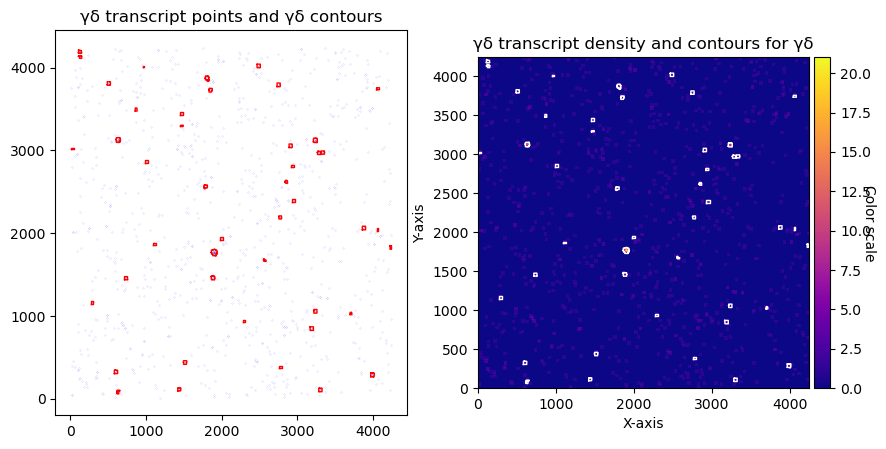

total contours found  175
total contours after filtering by area 45


In [7]:
CGD = contours.ConvolutionContours(array_subset_gd, contour_name='GD', logger=logger)
CGD.get_conv_sum(kernel_size=kernel_size_gd, kernel_shape='square')  #
CGD.contours_from_sum(density_threshold=density_th_gd,
                      min_area_threshold=min_area_th_gd, directionality='higher')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

CGD.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                              c_points='blue', c_contours='red', ax=axs[0])
axs[0].set_title('γδ transcript points and γδ contours')

CGD.plot_conv_sum(cmap='plasma', c_countour='white', path=None, ax=axs[1])
axs[1].set_title('γδ transcript density and contours for γδ')

plt.show()


print('total contours found ', CGD.total_valid_contours)
print('total contours after filtering by area', CGD.contours_filtered_area)

In this case, we are considering a possible object of γδ T cells (one or more) if there is at least 3 counts (>2) of the genes ['TRGC1','TRGC2','TRDC'] in a kernel size 45*45.

This is a very lenient threshold. One could use more stringent thresholds but risk to possible loose some cells. One shoudl design these parameters accordingly to the genes behaviour. γδ transcripts in CosMx are not express much.

As we are using light restrictions, some of the contours are not true γδ cells. For example, an artifact cluster of 3 TRGC1 genes would be considered. Also, in biological terms, it is necessary to also guarantee that the TRGC and TRDC are more expressed than the receptors B and C of other T cells.

We will define some filtering rules:

        * AB < GD :  counts of AB total counts in the contour needs to be lower than tota GD point counts. 
        * The contour should have at least 1 count of G and one count of D. G >0, D>0.
        
        
filter_contours_by_gene_comparison ->   Filters contours based on the comparison of gene counts between two gene arrays.Contours are kept if the gene count in `gene_array1` is greater than the gene count in `gene_array2` (`gene_array1`>`gene_array2`) 

filter_contours_by_gene_threshold -> Filters contours based on a gene count threshold. Contours are kept if the gene count is greater than or equal to the threshold (`gene_array`>=threshold). 


In [8]:
### Filtering 
CGD.filter_contours_by_gene_comparison(gene_array1 = array_subset_gd, gene_array2 = array_subset_ab,
                                       gene_name1 = "gd", gene_name2 = "ab") # gene 1 > gene2 --> valid contour 
# G>0 D>0
CGD.filter_contours_by_gene_threshold(gene_array = array_subset_d.squeeze(), threshold = 1, gene_name = 'TRDC')# >= 1
CGD.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_g, axis=-1), threshold = 1, gene_name = 'TRGC1_2')# >= 1
print('total contours found ', len(CGD.contours))

2025-05-28 12:41:09,410 - contour_logger - INFO - Excluding contour 21. Gene gd count 3.0 is not greater than gene ab count 5.0
2025-05-28 12:41:10,838 - contour_logger - INFO - Excluding contour 43. Gene gd count 3.0 is not greater than gene ab count 3.0
2025-05-28 12:41:10,903 - contour_logger - INFO - Excluding contour 44. Gene gd count 1.0 is not greater than gene ab count 1.0
2025-05-28 12:41:10,903 - contour_logger - INFO - Number of contours remaining: 42
2025-05-28 12:41:10,937 - contour_logger - INFO - Excluding contour 0. Gene TRDC count  0.0 is below threshold 1
2025-05-28 12:41:11,074 - contour_logger - INFO - Excluding contour 4. Gene TRDC count  0.0 is below threshold 1
2025-05-28 12:41:11,142 - contour_logger - INFO - Excluding contour 6. Gene TRDC count  0.0 is below threshold 1
2025-05-28 12:41:11,310 - contour_logger - INFO - Excluding contour 11. Gene TRDC count  0.0 is below threshold 1
2025-05-28 12:41:11,478 - contour_logger - INFO - Excluding contour 16. Gene TRD

total contours found  13


Lets plot the transcripts on top of DAPI images for better visuaization. 

In [9]:
%%time
%autoreload
from helper_plot import plot_TRGC_TRDC_points_polygons, plot_TRGC_TRDC_points_contours, plot_TRGC_TRDC_points_mask
from src.mask_properties import GetMaskPropertiesObject
from skimage.measure import label
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# # plot polygons with TRDC and TRGC points for cell boundaries
# img_points_dapi = plot_TRGC_TRDC_points_mask(segmentation_file_path, filtered_data_gd,dapi_file_path, figsize=(10, 10))
df_total = pd.read_csv(file_csv)
target_list = ['TRGC1/TRGC2', 'TRDC','TRBC1/TRBC2', ] # 'TRAC', 'CD8A', 'CD8B', 'CD4'
filtered_data_gd = df_total[df_total['target'].isin(target_list)]

dapi_file = [file for file in os.listdir(dapi_folder) if str(fov[3:]) in file][0]
dapi_file_path = os.path.join(dapi_folder, dapi_file)

img_gd_contour = plot_TRGC_TRDC_points_contours(CGD.contours, filtered_data_gd, dapi_file_path)


# centroids for GD
# GM = masks.GetMasks(image_shape=(height, width))

# SA = masks.SingleClassObjectAnalysis(GM, contours_object=CGD.contours)
# SA.get_mask_objects(exclude_masks=None)  # Not excluding any tum or empty 

# SA.get_objects_expansion(expansions_pixels=[10, 20, 30],
#                          exclude_masks=None)  # exclude from empty? or from tumour? Not excluding
# mask_GD = SA.mask_object_SA

# GMO = GetMaskPropertiesObject(mask_GD, label(mask_GD), array_counts = None, target_dict = None)
# GMO.get_morpho_properties()
# morpho_properties = GMO.properties
# centroids = [obj['centroid'] for obj in morpho_properties.values()]
# print('gd', centroids)

<built-in method max of numpy.ndarray object at 0x7f77a0ba77b0>
CPU times: user 3.61 s, sys: 284 ms, total: 3.9 s
Wall time: 3.98 s


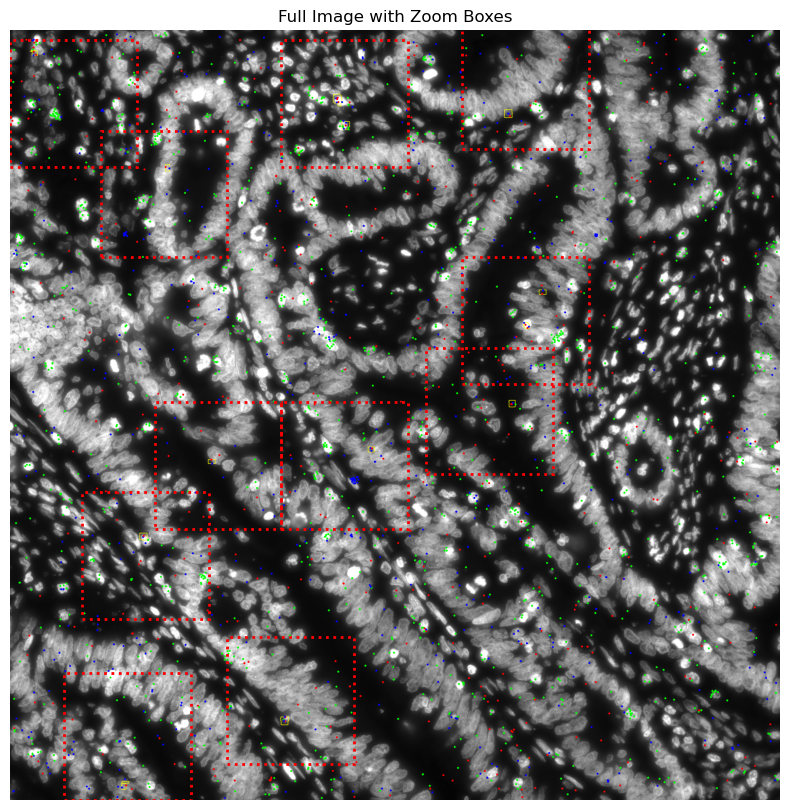

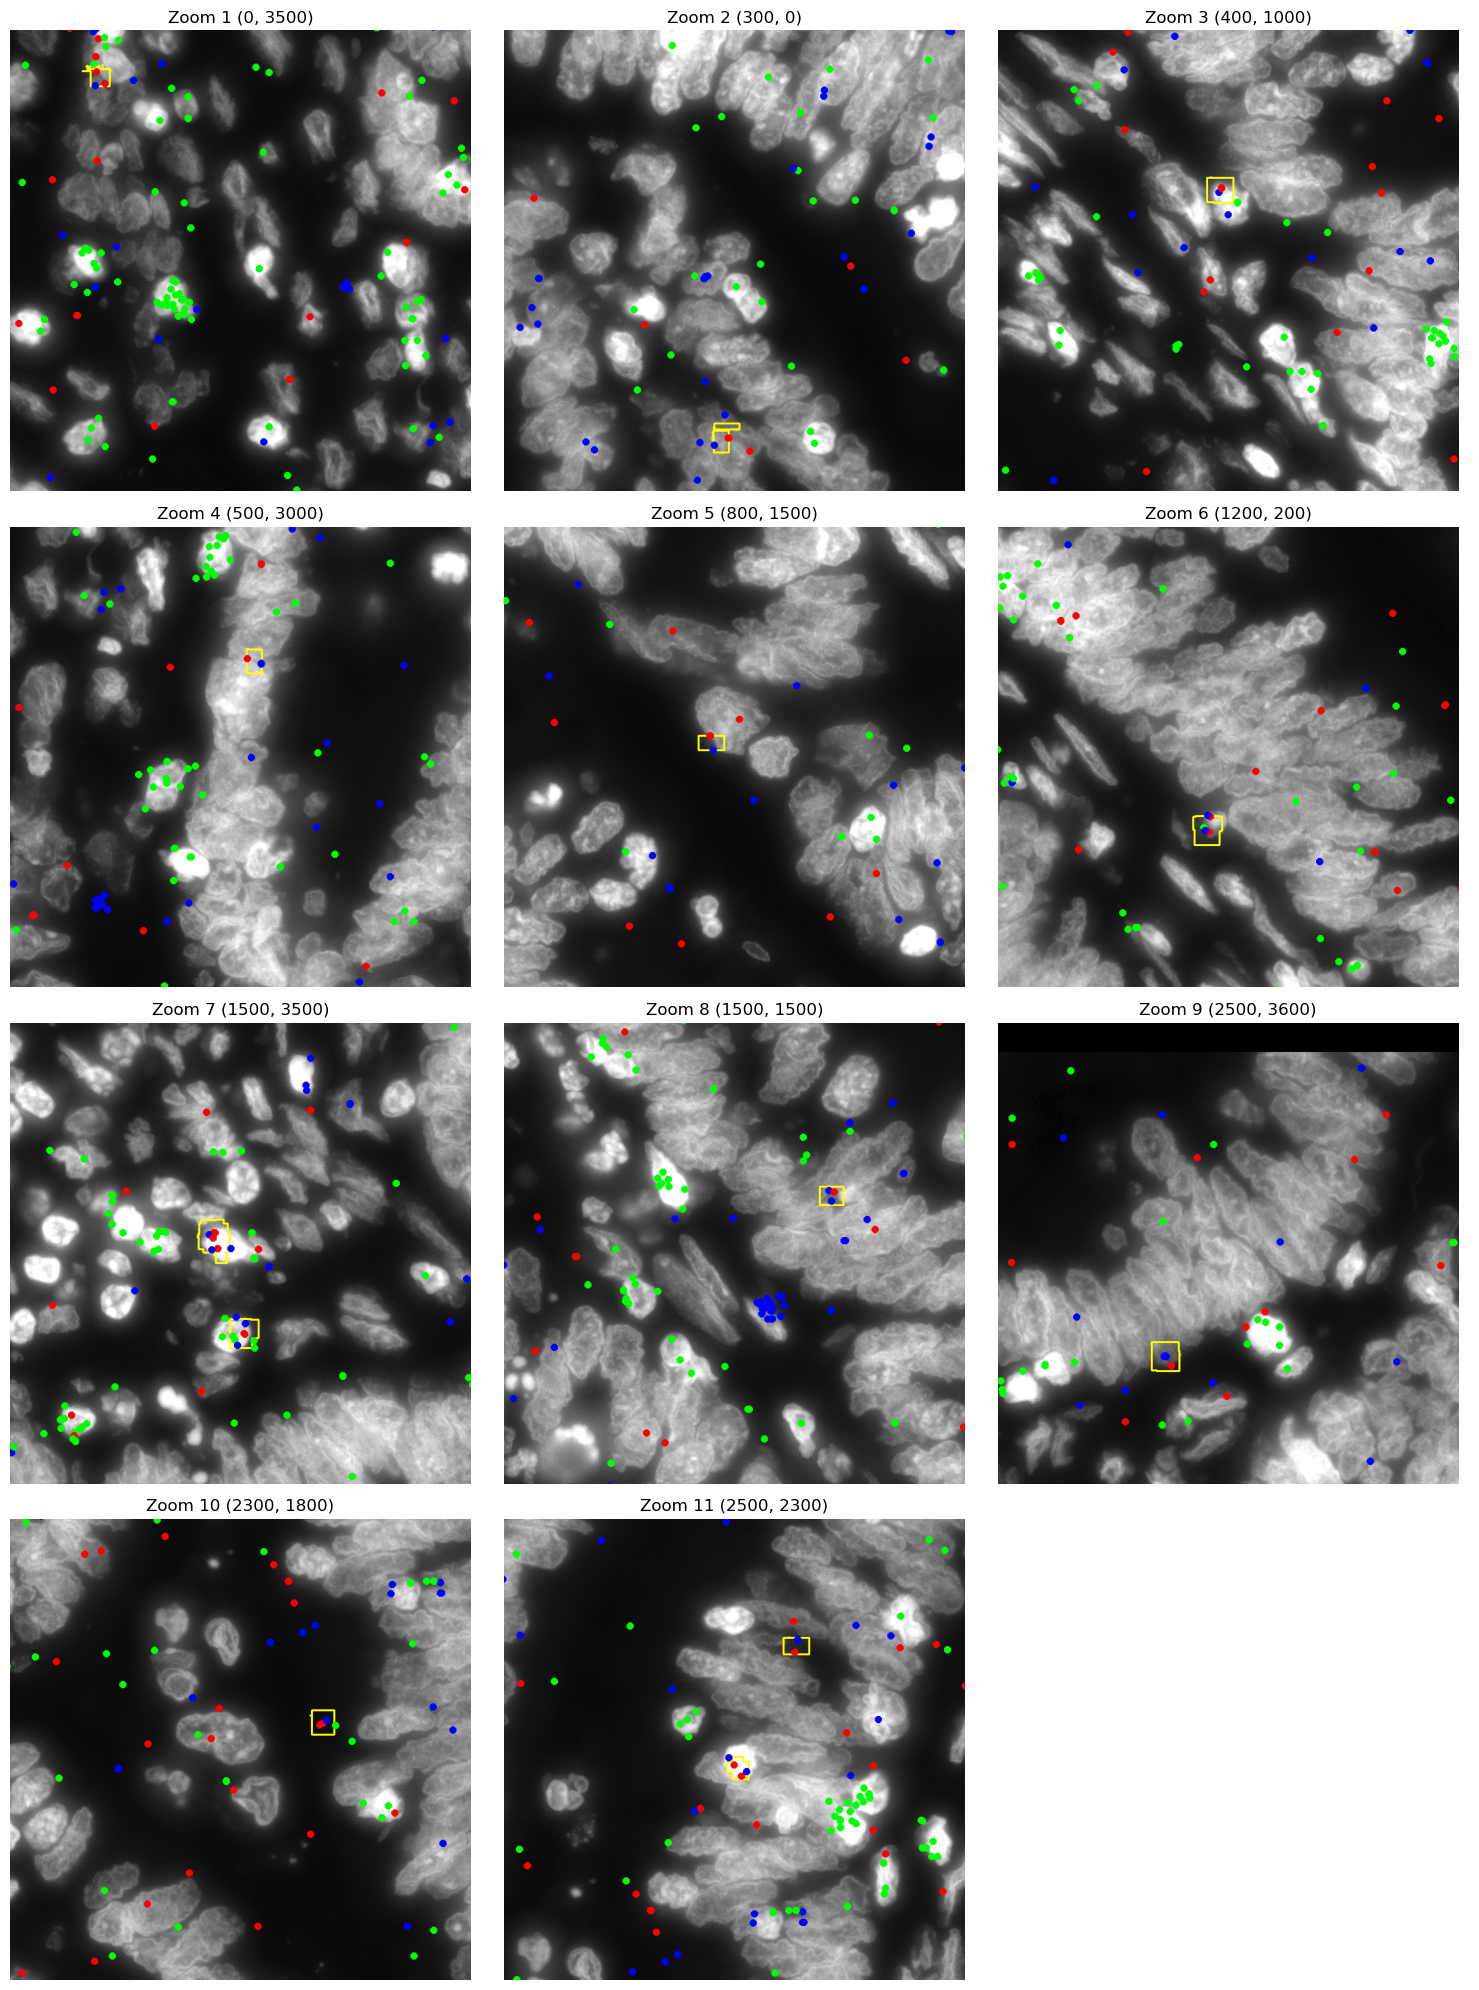

In [10]:
zoom_coords_fov7 = [
   (0,3500),  # (135.67423382519863, 4128.138479001135),
   (300,0), #(631.9569805194806, 81.96996753246754),
 (400,1000), #(737.3119551681195, 1455.9663760896638),
 (500,3000), #(870.4814814814815, 3494.063973063973),
 (800,1500), #(1114.5, 1870.0),
 (1200,200), #(1517.5759023354565, 437.6995753715499),
 (1500,3500), #(1810.3046566692976, 3871.5994475138123),
 (1500,1500), #(1997.0, 1937.0),
 (2500,3600), #(2753.920020909566, 3792.991113434396),
 (2300,1800), #(2774.9572393098274, 2190.523630907727),
 (2500,2300), #(2855.645518630413, 2620.5387713997984),
]
    
zoom_coords = zoom_coords_fov7  # your list of (x, y) points
zoom_size = 700  # size of the square to crop

# Plot full image with red rectangles ===
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_gd_contour, origin='lower')
ax.axis('off')
ax.set_title("Full Image with Zoom Boxes")

# Add red dotted rectangles
for zoom_x, zoom_y in zoom_coords:
    rect = patches.Rectangle(
        (zoom_x, zoom_y),
        zoom_size,
        zoom_size,
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        linestyle='dotted'
    )
    ax.add_patch(rect)

plt.show()

# Plot zoomed-in regions in a grid with 3 columns ===
num_coords = len(zoom_coords)
num_cols = 3
num_rows = (num_coords + num_cols - 1) // num_cols  # ceil division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

# If axes is 1D (single row), make it 2D for uniformity
if num_rows == 1:
    axes = [axes]

for idx, (zoom_x, zoom_y) in enumerate(zoom_coords):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row][col] if num_rows > 1 else axes[col]

    # Define bounding box for cropping
    box = (zoom_x, zoom_y, zoom_x + zoom_size, zoom_y + zoom_size)
    cropped_img = img_gd_contour.crop(box)

    ax.imshow(cropped_img, origin='lower')
    ax.axis('off')
    ax.set_title(f"Zoom {idx + 1} ({zoom_x}, {zoom_y})")

# Hide any unused subplots
for idx in range(num_coords, num_rows * num_cols):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row][col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
output_folder = "zoomed_crops_gd"
os.makedirs(output_folder, exist_ok=True)

width, height = img_gd_contour.size

for idx, (zoom_x, zoom_y) in tqdm(enumerate(zoom_coords)):
    # Clamp box to image boundaries
    right = min(zoom_x + zoom_size, width)
    lower = min(zoom_y + zoom_size, height)
    box = (zoom_x, zoom_y, right, lower)

    # Crop image
    cropped_img = img_gd_contour.crop(box)

    # Save to file
    output_path = os.path.join(output_folder, f"crop_{idx + 1:02d}.png")
    cropped_img.save(output_path)

11it [00:01, 10.88it/s]


# Multi class Object analysis - CD8+ and γδ
Following the same principles outlined in the single-object analysis, it is also possible to extend the approach to explore multiple object types simultaneously. While running the single-object analysis multiple times could achieve this, it does not account for overlapping areas between different object types. The multiclass object analysis resolves this by generating Voronoi diagrams, which constrain expansions to areas closer to one object type than to any other. This ensures that regions around object type A are strictly associated with A and not influenced by proximity to object type B.

We exemplify this approach using the previously defined γδ contours along with contours identifying CD8+ T-cell regions.

CD8+ T-cell regions were defined using a kernel size of 5.5 µm to identify areas containing more than two transcripts of CD8, TRAC, and TRBC. These regions were further filtered to ensure they contained more TRAC+TRBC transcripts than TRGC+TRDC transcripts, with at least one count of each transcript present.

The analysis includes differential gene expression profiling between areas surrounding γδ T cell and CD8+ T  cell regions, highlighting distinct transcriptomic patterns in their respective vicinities. 


***contours CD8***

Function 'get_conv_sum' took 0.4458 seconds to execute.
Function 'contours_from_sum' took 56.2100 seconds to execute.


2025-05-28 12:42:17,158 - contour_logger - INFO - Excluding contour 0. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:17,193 - contour_logger - INFO - Excluding contour 1. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:17,262 - contour_logger - INFO - Excluding contour 3. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:17,368 - contour_logger - INFO - Excluding contour 6. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:17,437 - contour_logger - INFO - Excluding contour 8. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:17,472 - contour_logger - INFO - Excluding contour 9. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:17,644 - contour_logger - INFO - Excluding contour 14. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:17,714 - contour_logger - INFO - Excluding contour 16. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:17,750 - contour_logger - INFO - Excluding contour 17. Gene CD8 count  0.0 is below t

2025-05-28 12:42:20,785 - contour_logger - INFO - Excluding contour 105. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:20,819 - contour_logger - INFO - Excluding contour 106. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:20,854 - contour_logger - INFO - Excluding contour 107. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:20,923 - contour_logger - INFO - Excluding contour 109. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:20,958 - contour_logger - INFO - Excluding contour 110. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:20,993 - contour_logger - INFO - Excluding contour 111. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:21,097 - contour_logger - INFO - Excluding contour 114. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:21,132 - contour_logger - INFO - Excluding contour 115. Gene CD8 count  0.0 is below threshold 1
2025-05-28 12:42:21,201 - contour_logger - INFO - Excluding contour 117. Gene CD8 count 

2025-05-28 12:42:24,084 - contour_logger - INFO - Excluding contour 15. Gene TRAC count  0.0 is below threshold 1
2025-05-28 12:42:24,169 - contour_logger - INFO - Excluding contour 18. Gene TRAC count  0.0 is below threshold 1
2025-05-28 12:42:24,198 - contour_logger - INFO - Excluding contour 19. Gene TRAC count  0.0 is below threshold 1
2025-05-28 12:42:24,312 - contour_logger - INFO - Excluding contour 23. Gene TRAC count  0.0 is below threshold 1
2025-05-28 12:42:24,341 - contour_logger - INFO - Excluding contour 24. Gene TRAC count  0.0 is below threshold 1
2025-05-28 12:42:24,372 - contour_logger - INFO - Excluding contour 25. Gene TRAC count  0.0 is below threshold 1
2025-05-28 12:42:24,402 - contour_logger - INFO - Excluding contour 26. Gene TRAC count  0.0 is below threshold 1
2025-05-28 12:42:24,517 - contour_logger - INFO - Excluding contour 30. Gene TRAC count  0.0 is below threshold 1
2025-05-28 12:42:24,546 - contour_logger - INFO - Excluding contour 31. Gene TRAC count 

total contours found  22


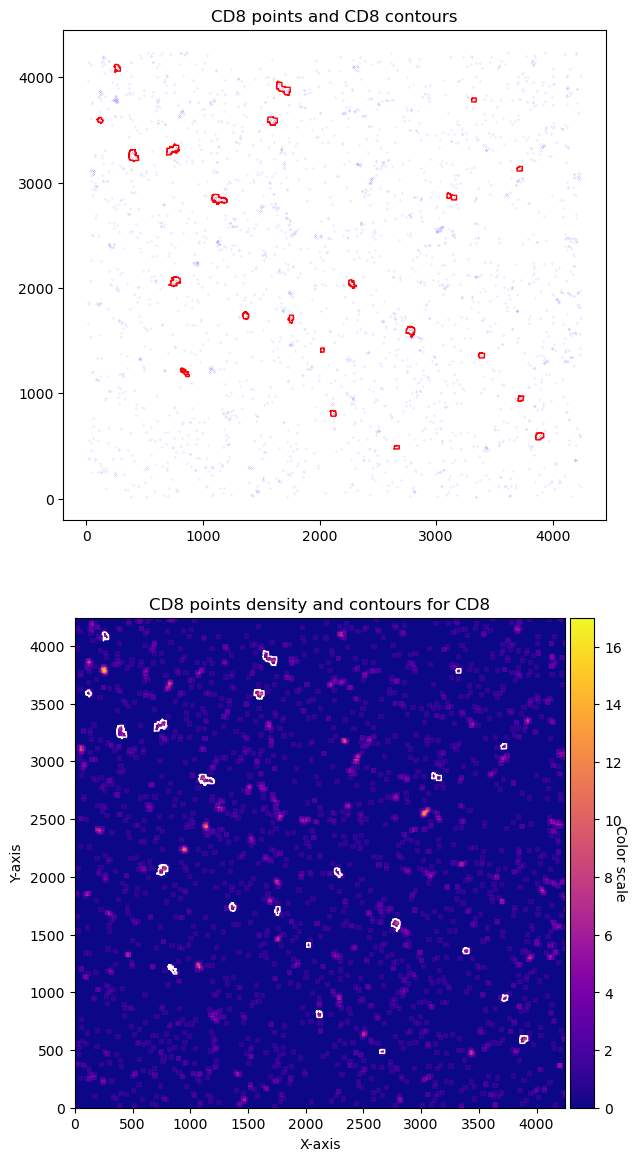

total contours found  22


In [12]:
density_th_cd8 = 2
min_area_th_cd8 = 5
kernel_size_cd8 = 45# 40


CCD8 = contours.ConvolutionContours(array_subset_cd8, contour_name='CD8', logger=logger)
CCD8.get_conv_sum(kernel_size=kernel_size_cd8, kernel_shape='square')  

CCD8.contours_from_sum(density_threshold=density_th_cd8,
                      min_area_threshold=min_area_th_cd8, directionality='higher')

CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_cd8_gene, axis=-1).squeeze(), threshold = 1, gene_name = 'CD8')# >= 1
CCD8.filter_contours_by_gene_threshold(gene_array = array_subset_TRAC_gene.squeeze(), threshold = 1, gene_name = 'TRAC')# >= 1
CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_TRBC_gene, axis=-1), threshold = 1, gene_name = 'TRBC1_2')# >= 1

# gene_counts_ab > gene_counts_gd

CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_ab, gene_array2 = array_subset_gd,
                                       gene_name1 = "ab", gene_name2 = "gd") # gene 1 > gene2 --> valid contour 


# CD8 > gene counts cd4 
CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_cd8_gene, gene_array2 = array_subset_cd4_gene,
                                       gene_name1 = "CD8", gene_name2 = "CD4") # gene 1 > gene2 --> valid contour
print('total contours found ', len(CCD8.contours))




fig, axs = plt.subplots(2, 1, figsize=(7, 14))

CCD8.plot_contours_scatter(path=None, show=False, s=0.05, alpha=0.5, linewidth=1,
                              c_points='blue', c_contours='red', ax=axs[0])
axs[0].set_title('CD8 points and CD8 contours')

CCD8.plot_conv_sum(cmap='plasma', c_countour='white', path=None, ax=axs[1])
axs[1].set_title('CD8 points density and contours for CD8')

plt.show()

print('total contours found ', len(CCD8.contours))

***Multi class object***

We have now CD8 and γδ contours, we will use the multiclass object analysis to derive the masks and their expansions without overlapping. 

For this, MultiClassObjectAnalysis, uses the given contours and derive Voronoi polygons based on the centroids of the contours. The expansions, 10 , 20 and 30, are allowed fo reach contour only inside its Voronoi polygon. 

INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.


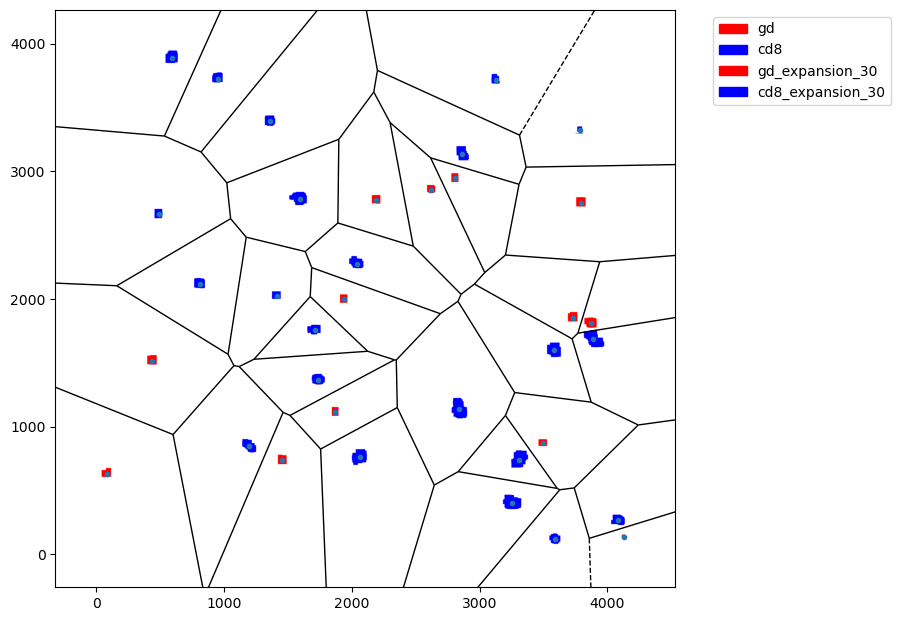

In [14]:
from src.masks import MultiClassObjectAnalysis
GM = masks.GetMasks(image_shape=(height, width))

multiple_contours = {'gd': CGD.contours,
                    'cd8': CCD8.contours}

MCA = MultiClassObjectAnalysis(GM, multiple_contours,
                                # mask_T= mask_tumour_overall,mask_S =mask_stroma_overall,
                                )    # save path 

MCA.derive_voronoi_from_contours_approximate()
# masks = MCA.generate_expanded_masks_limited_by_voronoi(expansion_distances=(10,20,30))

# mask_colors = {
# 'gd': (255, 0, 0),          # red
# 'gd_expansion_10': (255, 0, 0), # light red
# 'gd_expansion_20': (255, 0, 0),   # medium red
# 'gd_expansion_30': (255, 0, 0), # dark red

# 'cd8': (0, 0, 255),         # blue
# 'cd8_expansion_10': (0, 0, 255),# light blue
# 'cd8_expansion_20': (0, 0, 255),  # medium blue
# 'cd8_expansion_30': (0, 0, 255) # dark blue  
# }

masks = MCA.generate_expanded_masks_limited_by_voronoi(expansion_distances=(30,))

mask_colors = {
'gd': (255, 0, 0),          # red
'gd_expansion_30': (255, 0, 0), # dark red

'cd8': (0, 0, 255),         # blue
'cd8_expansion_30': (0, 0, 255) # dark blue  
}


MCA.plot_contours_expansion_with_voronoi_edges(mask_colors, show=True)


***Explore full cohort***

In [44]:
%%time
from src import masks

# Custom logger setup - Will set to warning
logger = logging.getLogger('contour_logger')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.WARNING)

save_path_ = 'results/multobj_cosmx/'
if not os.path.exists(save_path_):
    os.makedirs(save_path_)
    
for file_csv in tqdm(files_cosmx, desc="Processing Folders", unit="folder"):
    start_time_lap = time.time()
    logger.info(f'Processing folder {file_csv}')
    base_name = os.path.basename(file_csv)

    fov_match = re.search(r'FOV\d+', file_csv)
    fov_part = fov_match.group()
    if fov_part == "FOV004":
        continue
    save_path = os.path.join(save_path_, fov_part)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if os.path.exists(os.path.join(save_path + f'/{fov_part}_simple_gd.csv')):
        continue
        
    df_total = pd.read_csv(file_csv)
    df_total = df_total.rename(columns={'x': 'X', 'y': 'Y'})
    df_total = df_total[~df_total['target'].str.contains('System|egative')]
    
    n_genes = len(df_total['target'].unique())
    height = int(max(df_total['X'])) + 1
    width = int(max(df_total['Y'])) + 1
    
    # arrays
    target_dict_total = {target: index for index, target in enumerate(df_total['target'].unique())}
    array_total = ga.transform_df_to_array(df = df_total, target_dict=target_dict_total, array_shape = (height, width,len(target_dict_total))).astype(np.int8)
    
    df_subset_gd, array_subset_gd, target_indices_subset_gd = ga.get_subset_arrays(df_total, array_total,
                                                                                       target_dict_total,
                                                                                       target_list=target_gd,
                                                                               target_col='target')
    
    df_subset_ab, array_subset_ab, target_indices_subset_ab = ga.get_subset_arrays(df_total, array_total,
                                                                                           target_dict_total,
                                                                                           target_list=target_ab,
                                                                                           target_col='target')
        
        
    df_subset_g, array_subset_g, target_indices_subset_g = ga.get_subset_arrays(df_total, array_total,
                                                                                           target_dict_total,
                                                                                           target_list=['TRGC1/TRGC2'],
                                                                                           target_col='target')
        
    df_subset_d, array_subset_d, target_indices_subset_d = ga.get_subset_arrays(df_total, array_total,
                                                                                           target_dict_total,
                                                                                           target_list=['TRDC'],
                                                                                           target_col='target')
    
    
    df_subset_tum, array_subset_tum, target_indices_subset_tum = ga.get_subset_arrays(df_total, array_total,target_dict_total,
                                                                             target_list=target_tum, target_col = 'target')
    
    
    df_subset_cd8, array_subset_cd8, target_indices_subset_cd8 = ga.get_subset_arrays(df_total, array_total,
                                                                                          target_dict_total,
                                                                                          target_list=target_cd8,
                                                                                          target_col='target')
                                                                                   
    
    df_subset_TRAC_gene, array_subset_TRAC_gene, target_indices_subset_TRAC_gene = ga.get_subset_arrays(df_total, 
                                                                                                     array_total,
                                                                                          target_dict_total,
                                                                                          target_list= ['TRAC'],
                                                                                          target_col='target')
    
    df_subset_TRBC_gene, array_subset_TRBC_gene, target_indices_subset_TRBC_gene = ga.get_subset_arrays(df_total, 
                                                                                                     array_total,
                                                                                          target_dict_total,
                                                                                          target_list= ['TRBC1/TRBC2'],
                                                                                          target_col='target')
    
    
    df_subset_cd8_gene, array_subset_cd8_gene, target_indices_subset_cd8_gene = ga.get_subset_arrays(df_total, 
                                                                                                     array_total,
                                                                                          target_dict_total,
                                                                                          target_list= ['CD8A', 'CD8B'],
                                                                                          target_col='target')
    
    df_subset_cd4_gene, array_subset_cd4_gene, target_indices_subset_cd4_gene = ga.get_subset_arrays(df_total, 
                                                                                                     array_total,
                                                                                          target_dict_total,
                                                                                          target_list= ['CD4'],
                                                                                          target_col='target')
    
    CGD = contours.ConvolutionContours(array_subset_gd, contour_name='GD', logger=logger)
    CGD.get_conv_sum(kernel_size=kernel_size_gd, kernel_shape='square')  #
    CGD.contours_from_sum(density_threshold=density_th_gd,
                          min_area_threshold=min_area_th_gd, directionality='higher')
    
    ### Filtering 
    CGD.filter_contours_by_gene_comparison(gene_array1 = array_subset_gd, gene_array2 = array_subset_ab,
                                           gene_name1 = "gd", gene_name2 = "ab") # gene 1 > gene2 --> valid contour 
    # G>0 D>0
    CGD.filter_contours_by_gene_threshold(gene_array = array_subset_d.squeeze(), threshold = 1, gene_name = 'TRDC')# >= 1
    CGD.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_g, axis=-1), threshold = 1, gene_name = 'TRGC1_2')# >= 1
    
    # CD8
    CCD8 = contours.ConvolutionContours(array_subset_cd8, contour_name='CD8', logger=logger)
    CCD8.get_conv_sum(kernel_size=kernel_size_cd8, kernel_shape='square')  
    
    CCD8.contours_from_sum(density_threshold=density_th_cd8,
                          min_area_threshold=min_area_th_cd8, directionality='higher')
    
    CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_cd8_gene, axis=-1).squeeze(), threshold = 1, gene_name = 'CD8')# >= 1
    CCD8.filter_contours_by_gene_threshold(gene_array = array_subset_TRAC_gene.squeeze(), threshold = 1, gene_name = 'TRAC')# >= 1
    CCD8.filter_contours_by_gene_threshold(gene_array = np.sum(array_subset_TRBC_gene, axis=-1), threshold = 1, gene_name = 'TRBC1_2')# >= 1
    
    # gene_counts_ab > gene_counts_gd
    
    CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_ab, gene_array2 = array_subset_gd,
                                           gene_name1 = "ab", gene_name2 = "gd") # gene 1 > gene2 --> valid contour 
    
    
    # CD8 > gene counts cd4 
    CCD8.filter_contours_by_gene_comparison(gene_array1 = array_subset_cd8_gene, gene_array2 = array_subset_cd4_gene,
                                           gene_name1 = "CD8", gene_name2 = "CD4") # gene 1 > gene2 --> valid contour

    
    GM = masks.GetMasks(image_shape=(height, width))
    
    multiple_contours = {'gd': CGD.contours,
                        'cd8': CCD8.contours}
    
    MCA = MultiClassObjectAnalysis(GM, multiple_contours) 
    
    MCA.derive_voronoi_from_contours_approximate()
    masks_MCA = MCA.generate_expanded_masks_limited_by_voronoi(expansion_distances=(20,))

    masks_analysis_tb = [
        {'mask': masks_MCA['gd'], 'mask_name': 'gd', 'per_object': True},
        {'mask': masks_MCA['gd_expansion_20'], 'mask_name': 'gd_expansion_20', 'per_object': True},    
        {'mask': masks_MCA['cd8'], 'mask_name': 'cd8', 'per_object': True},
        {'mask': masks_MCA['cd8_expansion_20'], 'mask_name': 'cd8_expansion_20', 'per_object': True},
    ]
    
    GP = GetMasksProperties(masks_dict = masks_analysis_tb,array_counts = array_total,
                            target_dict = target_dict_total,
                            logger = logger, image_shape = (height, width), save_path = None)

    GP.get_gene_counts(workers = None)
    GP.save_df(os.path.join(save_path + f'/{fov_part}_mob.csv'))


Processing Folders:   0%|                                                                                                                                | 0/20 [00:00<?, ?folder/s]

Function 'get_conv_sum' took 0.4135 seconds to execute.
Function 'contours_from_sum' took 2.2261 seconds to execute.
Function 'get_conv_sum' took 0.4230 seconds to execute.
Function 'contours_from_sum' took 465.7174 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV001/FOV001_mob.csv
Processing Folders:   5%|█████▋                                                                                                           | 1/20 [1:03:32<20:07:25, 3812.91s/folder]

Function 'get_gene_counts' took 3265.1248 seconds to execute.
Function 'get_conv_sum' took 0.4168 seconds to execute.
Function 'contours_from_sum' took 14.2719 seconds to execute.
Function 'get_conv_sum' took 0.4391 seconds to execute.
Function 'contours_from_sum' took 175.9117 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV002/FOV002_mob.csv
Processing Folders:  10%|███████████▎                                                                                                     | 2/20 [1:34:32<13:19:09, 2663.86s/folder]

Function 'get_gene_counts' took 1616.0010 seconds to execute.
Function 'get_conv_sum' took 0.4154 seconds to execute.
Function 'contours_from_sum' took 2.5865 seconds to execute.
Function 'get_conv_sum' took 0.4223 seconds to execute.
Function 'contours_from_sum' took 96.8103 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV003/FOV003_mob.csv
Processing Folders:  15%|█████████████████                                                                                                 | 3/20 [1:45:14<8:13:11, 1740.70s/folder]

Function 'get_gene_counts' took 507.5635 seconds to execute.
Function 'get_conv_sum' took 0.4189 seconds to execute.
Function 'contours_from_sum' took 2.4344 seconds to execute.
Function 'get_conv_sum' took 0.4197 seconds to execute.
Function 'contours_from_sum' took 18.0208 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV005/FOV005_mob.csv
Processing Folders:  25%|████████████████████████████▊                                                                                      | 5/20 [1:55:16<3:51:24, 925.63s/folder]

Function 'get_gene_counts' took 548.6625 seconds to execute.
Function 'get_conv_sum' took 0.4134 seconds to execute.
Function 'contours_from_sum' took 2.4048 seconds to execute.
Function 'get_conv_sum' took 0.4361 seconds to execute.
Function 'contours_from_sum' took 114.9730 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV006/FOV006_mob.csv
Processing Folders:  30%|██████████████████████████████████▏                                                                               | 6/20 [2:18:13<4:06:18, 1055.60s/folder]

Function 'get_gene_counts' took 1217.8316 seconds to execute.
Function 'get_conv_sum' took 0.4374 seconds to execute.
Function 'contours_from_sum' took 6.1544 seconds to execute.
Function 'get_conv_sum' took 0.4440 seconds to execute.
Function 'contours_from_sum' took 57.3300 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV007/FOV007_mob.csv
Processing Folders:  35%|███████████████████████████████████████▉                                                                          | 7/20 [2:32:46<3:37:10, 1002.37s/folder]

Function 'get_gene_counts' took 767.6219 seconds to execute.
Function 'get_conv_sum' took 0.4298 seconds to execute.
Function 'contours_from_sum' took 3.7065 seconds to execute.
Function 'get_conv_sum' took 0.4213 seconds to execute.
Function 'contours_from_sum' took 102.1111 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV008/FOV008_mob.csv
Processing Folders:  40%|█████████████████████████████████████████████▌                                                                    | 8/20 [2:59:07<3:54:30, 1172.54s/folder]

Function 'get_gene_counts' took 1432.2251 seconds to execute.
Function 'get_conv_sum' took 0.4313 seconds to execute.
Function 'contours_from_sum' took 0.9183 seconds to execute.
Function 'get_conv_sum' took 0.4436 seconds to execute.
Function 'contours_from_sum' took 44.9456 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV009/FOV009_mob.csv
Processing Folders:  45%|███████████████████████████████████████████████████▎                                                              | 9/20 [3:09:42<3:05:47, 1013.44s/folder]

Function 'get_gene_counts' took 554.6989 seconds to execute.
Function 'get_conv_sum' took 0.4254 seconds to execute.
Function 'contours_from_sum' took 2.4347 seconds to execute.
Function 'get_conv_sum' took 0.4357 seconds to execute.
Function 'contours_from_sum' took 27.9096 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV010/FOV010_mob.csv
Processing Folders:  50%|█████████████████████████████████████████████████████████                                                         | 10/20 [3:21:27<2:33:38, 921.88s/folder]

Function 'get_gene_counts' took 643.3508 seconds to execute.
Function 'get_conv_sum' took 0.4112 seconds to execute.
Function 'contours_from_sum' took 0.9974 seconds to execute.
Function 'get_conv_sum' took 0.4324 seconds to execute.
Function 'contours_from_sum' took 120.3118 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV011/FOV011_mob.csv
Processing Folders:  55%|██████████████████████████████████████████████████████████████▏                                                  | 11/20 [3:43:27<2:36:04, 1040.51s/folder]

Function 'get_gene_counts' took 1153.6731 seconds to execute.
Function 'get_conv_sum' took 0.4266 seconds to execute.
Function 'contours_from_sum' took 0.8055 seconds to execute.
Function 'get_conv_sum' took 0.4436 seconds to execute.
Function 'contours_from_sum' took 7.5334 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV012/FOV012_mob.csv
Processing Folders:  60%|████████████████████████████████████████████████████████████████████▍                                             | 12/20 [3:45:50<1:42:59, 772.46s/folder]

Function 'get_gene_counts' took 112.8933 seconds to execute.
Function 'get_conv_sum' took 0.4407 seconds to execute.
Function 'contours_from_sum' took 0.9975 seconds to execute.
Function 'get_conv_sum' took 0.4488 seconds to execute.
Function 'contours_from_sum' took 30.0705 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV013/FOV013_mob.csv
Processing Folders:  65%|██████████████████████████████████████████████████████████████████████████                                        | 13/20 [3:53:30<1:19:13, 679.07s/folder]

Function 'get_gene_counts' took 397.9487 seconds to execute.
Function 'get_conv_sum' took 0.4354 seconds to execute.
Function 'contours_from_sum' took 2.1058 seconds to execute.
Function 'get_conv_sum' took 0.4383 seconds to execute.
Function 'contours_from_sum' took 55.3519 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV014/FOV014_mob.csv
Processing Folders:  70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 14/20 [4:09:33<1:16:25, 764.31s/folder]

Function 'get_gene_counts' took 870.0010 seconds to execute.
Function 'get_conv_sum' took 0.4280 seconds to execute.
Function 'contours_from_sum' took 2.2826 seconds to execute.
Function 'get_conv_sum' took 0.4271 seconds to execute.
Function 'contours_from_sum' took 75.3825 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV015/FOV015_mob.csv
Processing Folders:  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 15/20 [4:24:16<1:06:38, 799.74s/folder]

Function 'get_gene_counts' took 764.2759 seconds to execute.
Function 'get_conv_sum' took 0.4123 seconds to execute.
Function 'contours_from_sum' took 2.5974 seconds to execute.
Function 'get_conv_sum' took 0.4209 seconds to execute.
Function 'contours_from_sum' took 429.1176 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV016/FOV016_mob.csv
Processing Folders:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 16/20 [5:35:10<2:02:19, 1834.85s/folder]

Function 'get_gene_counts' took 3744.0587 seconds to execute.
Function 'get_conv_sum' took 0.4189 seconds to execute.
Function 'contours_from_sum' took 3.2056 seconds to execute.
Function 'get_conv_sum' took 0.4272 seconds to execute.
Function 'contours_from_sum' took 26.9643 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV017/FOV017_mob.csv
Processing Folders:  85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 17/20 [5:45:59<1:13:57, 1479.24s/folder]

Function 'get_gene_counts' took 586.7590 seconds to execute.
Function 'get_conv_sum' took 0.4187 seconds to execute.
Function 'contours_from_sum' took 3.7484 seconds to execute.
Function 'get_conv_sum' took 0.4389 seconds to execute.
Function 'contours_from_sum' took 12.5507 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV018/FOV018_mob.csv
Processing Folders:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 18/20 [5:51:12<37:39, 1129.78s/folder]

Function 'get_gene_counts' took 271.2151 seconds to execute.
Function 'get_conv_sum' took 0.4343 seconds to execute.
Function 'contours_from_sum' took 1.6071 seconds to execute.
Function 'get_conv_sum' took 0.4420 seconds to execute.
Function 'contours_from_sum' took 127.4004 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
INFO:root:Dataframe saved to results/multobj_cosmx/FOV019/FOV019_mob.csv
Processing Folders:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 19/20 [6:11:14<19:11, 1151.21s/folder]

Function 'get_gene_counts' took 1028.0395 seconds to execute.
Function 'get_conv_sum' took 0.4204 seconds to execute.
Function 'contours_from_sum' took 0.4346 seconds to execute.
Function 'get_conv_sum' took 0.4448 seconds to execute.
Function 'contours_from_sum' took 8.7204 seconds to execute.


INFO:src.masks:Tumour mask not defined.
INFO:src.masks:Stroma mask not defined.
Processing Folders:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 19/20 [6:11:42<19:33, 1173.80s/folder]


QhullError: QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull v Qbb Qz Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 231919332  voronoi  Qbbound-last  Qz-infinity-point  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0


***analysis of results***

In [9]:
save_path_ = 'results/multobj_cosmx/'

dfs = []
for file_csv in files_cosmx: 
    fov_match = re.search(r'FOV\d+', file_csv)
    fov_part = fov_match.group()
    if fov_part in ['FOV004', 'FOV020', ]: # 'FOV018','FOV019'
        continue
    base_name = os.path.basename(file_csv)

    df = pd.read_csv(os.path.join(os.path.join(save_path_, fov_part) + f'/{fov_part}_mob.csv'))
    df['selection'] = fov_part
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)
full_df

full_df['mask_name'].value_counts()
full_df.head()

mask_name  object_id    area    perimeter  \
0               cd8          1  6624.0   579.906638   
1  cd8_expansion_20          1  4842.0  1087.753355   
2                gd          1  1290.0   142.000000   
3   gd_expansion_20          1  1748.0   365.656854   
4               cd8          2  3826.0   368.509668   

                                            centroid  min_x  min_y  max_x  \
0  (np.float64(52.421195652173914), np.float64(55...    495      7    603   
1  (np.float64(57.93411813300289), np.float64(557...    486      0    613   
2              (np.float64(183.5), np.float64(80.0))     59    169    102   
3  (np.float64(184.36899313501144), np.float64(80...     50    160    112   
4  (np.float64(43.46602195504443), np.float64(248...   2448      8   2541   

   max_y  vertices  ... NRXN1  CCL26  RSPO3  CYP2U1  FZD7  TTR  RPS4Y1  LGR5  \
0    109      6624  ...     0      0      0       0     0    0       0     0   
1    119      4842  ...     0      0      0       0     0    0       0     0   
2    199      1290  ...     0      0      0       0     0    0       0     0   
3    209      1748  ...     0      0      0       0     0    0       0     0   
4     81      3826  ...     0      1      0       0     0    0       0     0   

   per_object  selection  
0        True     FOV001  
1        True     FOV001  
2        True     FOV001  
3        True     FOV001  
4        True     FOV001  

[5 rows x 1012 columns]

Transform into adata object

In [10]:
import anndata as ad
obs_columns = ['area', 'perimeter', 'centroid', 'min_x', 'min_y', 'max_x', 'max_y', 'vertices', 
               'BoundingBox', 'mask_name', 'per_object', 'selection', 'object_id']
counts_columns = full_df.columns.difference(obs_columns)
counts = full_df[counts_columns]

obs = full_df[obs_columns]


adata = ad.AnnData(counts)
adata.obs = obs
adata.layers["counts"] = adata.X.copy()
adata.obs.head()

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


area    perimeter                                           centroid  \
0  6624.0   579.906638  (np.float64(52.421195652173914), np.float64(55...   
1  4842.0  1087.753355  (np.float64(57.93411813300289), np.float64(557...   
2  1290.0   142.000000              (np.float64(183.5), np.float64(80.0))   
3  1748.0   365.656854  (np.float64(184.36899313501144), np.float64(80...   
4  3826.0   368.509668  (np.float64(43.46602195504443), np.float64(248...   

   min_x  min_y  max_x  max_y  vertices            BoundingBox  \
0    495      7    603    109      6624   [(7, 495, 109, 603)]   
1    486      0    613    119      4842   [(0, 486, 119, 613)]   
2     59    169    102    199      1290  [(169, 59, 199, 102)]   
3     50    160    112    209      1748  [(160, 50, 209, 112)]   
4   2448      8   2541     81      3826  [(8, 2448, 81, 2541)]   

          mask_name  per_object selection  object_id  
0               cd8        True    FOV001          1  
1  cd8_expansion_20        True    FOV001          1  
2                gd        True    FOV001          1  
3   gd_expansion_20        True    FOV001          1  
4               cd8        True    FOV001          2

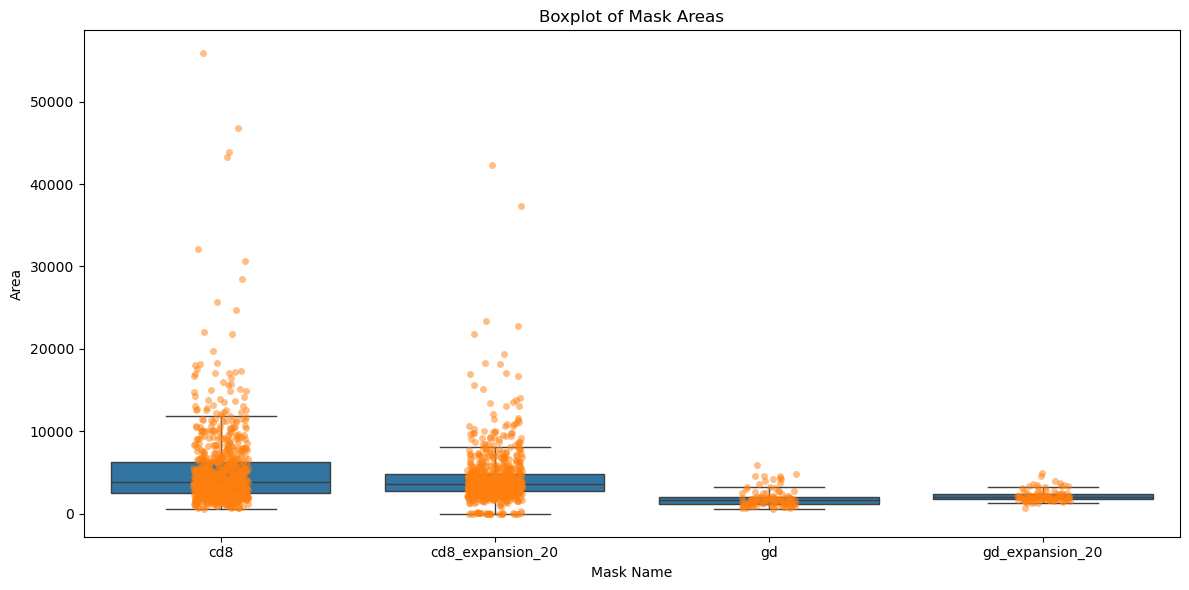

In [11]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(x='mask_name', y='area', data=adata.obs, showfliers=False)

# Overlay the points
sns.stripplot(x='mask_name', y='area', data=adata.obs, alpha=0.5)

plt.title('Boxplot of Mask Areas')
plt.xlabel('Mask Name')
plt.ylabel('Area')
plt.tight_layout()
plt.show()

Normalization

We will normalize the values, as it was single cell data

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:243: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


Elbow at:  13


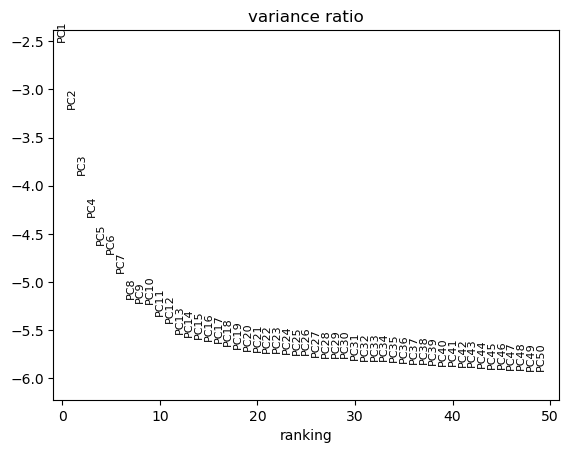

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


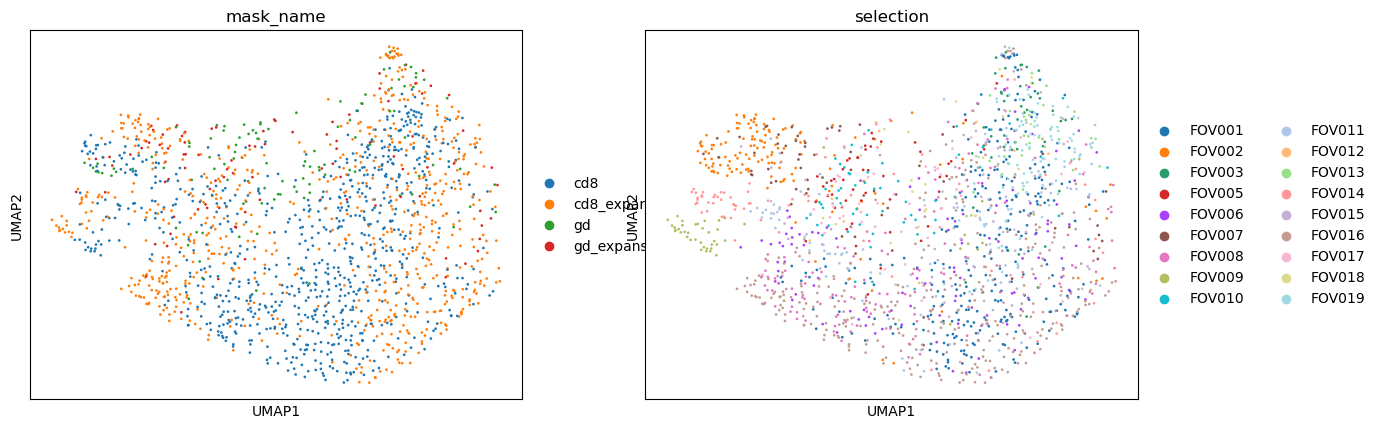

In [13]:
import scanpy as sc
# Normalize the counts in the 'X' matrix
adata.X = np.nan_to_num(adata.X / adata.obs['area'].values[:, None])*100
# sc.pp.scale(adata)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.tl.pca(adata)
pct = adata.uns['pca']['variance_ratio'] / sum(adata.uns['pca']['variance_ratio']) * 100
cumu = np.cumsum(pct)
# Point 1.
co1 = list(np.where(np.logical_and(cumu > 90, pct < 5))[0])[0]
# Point 2.
x = list(np.where(pct[0:len(pct)-1] - pct[1:len(pct)] > 0.1)[0])
x.sort(reverse=True)
co2 = x[0]+1
# Elbow:
elbow = min(co1, co2) + 1 # Without the +1, it gives the index and not the PC number
                          # (indices in python start with 0, unlike R that start with 1)
print('Elbow at: ', elbow)

sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

sc.pp.neighbors(adata, n_neighbors=20) #, n_pcs=elbow)

sc.tl.umap(adata) 

sc.pl.umap(
    adata,
    color= ["mask_name", "selection"],
    size=15,
)

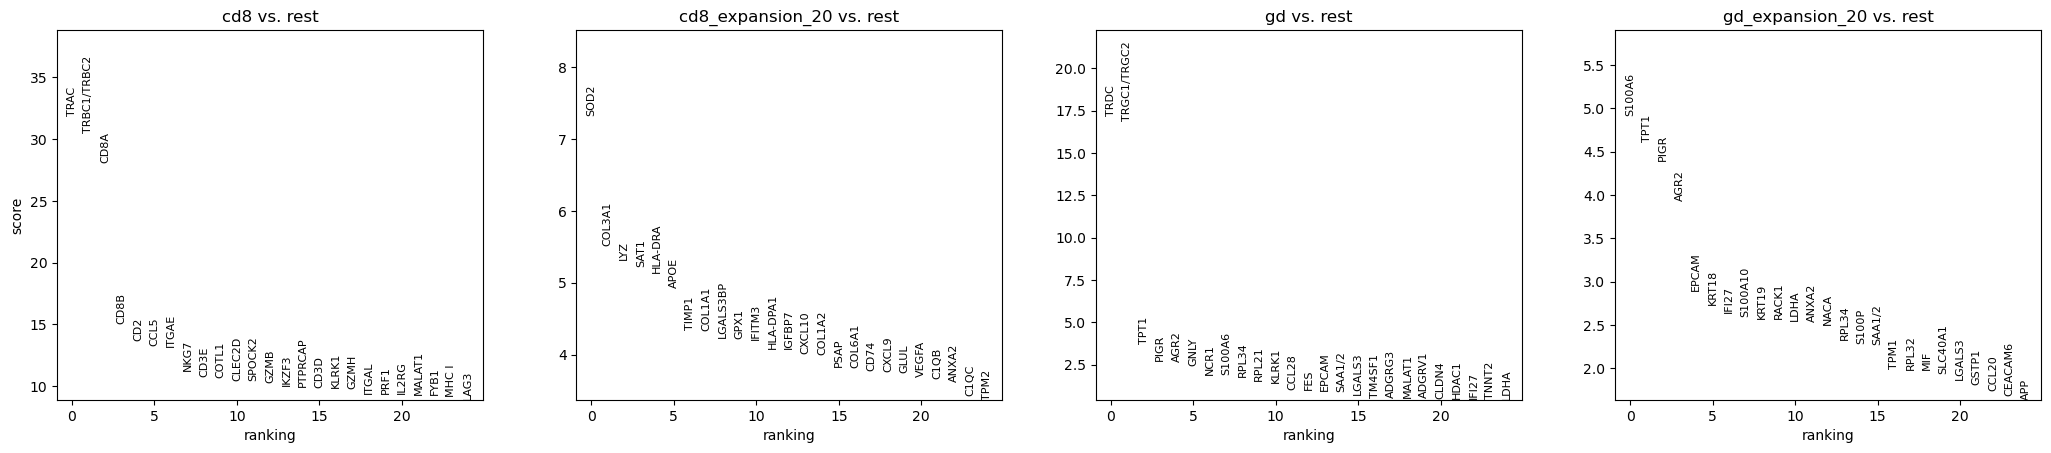

In [14]:
sc.tl.rank_genes_groups(adata, "mask_name", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

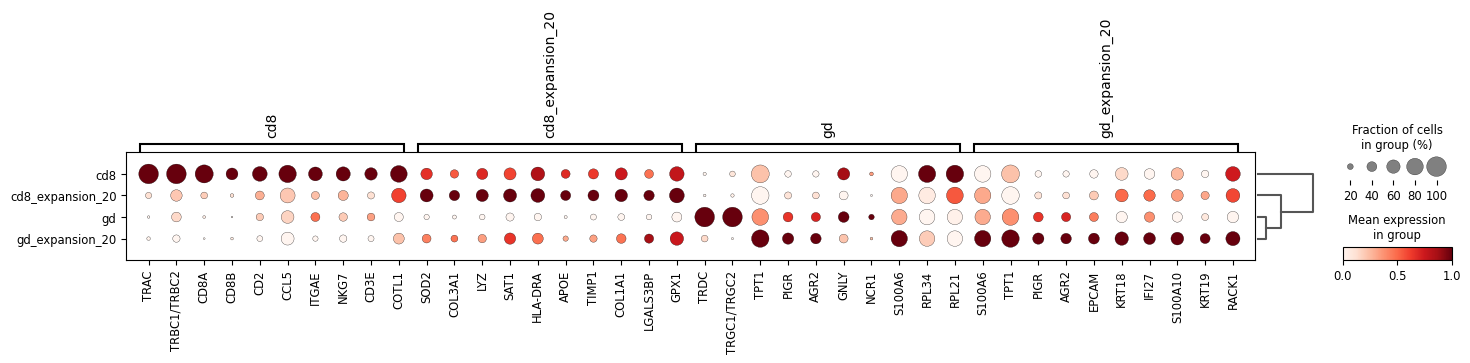

In [15]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="mask_name", standard_scale="var", n_genes=10)

Just the expansions

/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/martinha/miniconda3/envs/GRIDGEN/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


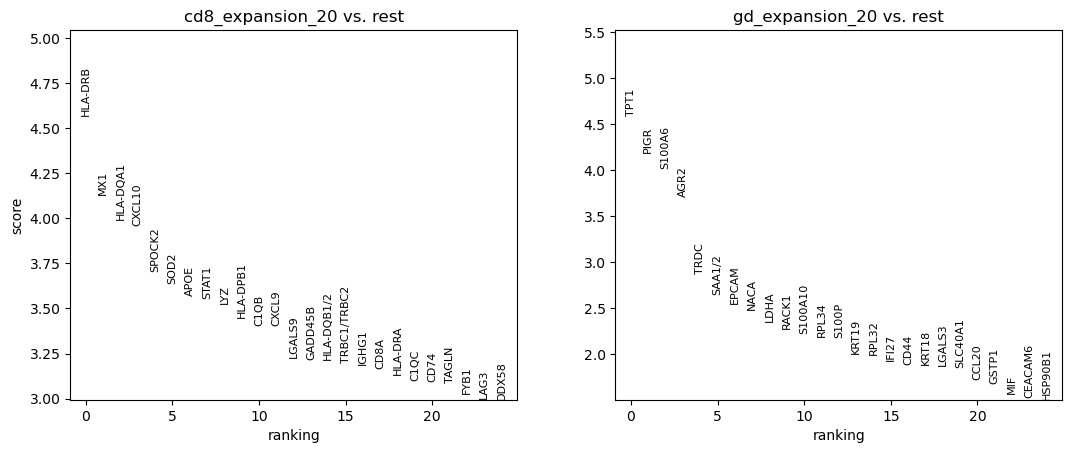

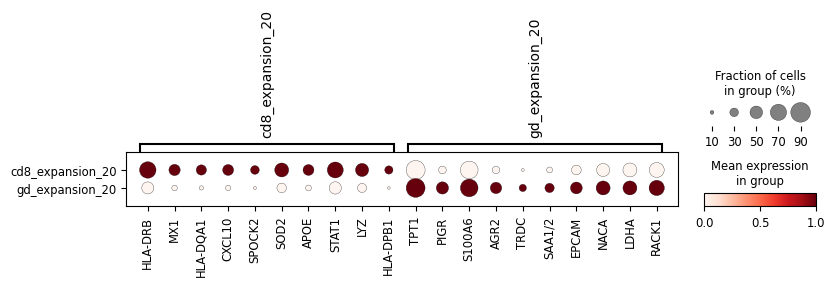

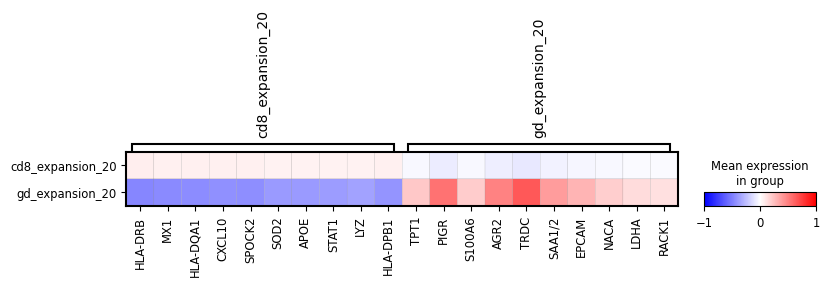

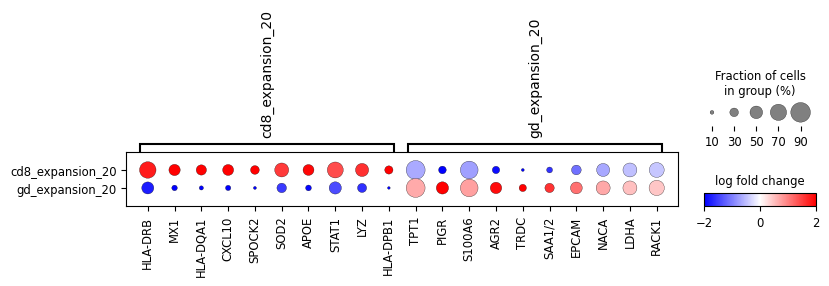

In [17]:
cl1 = adata[adata.obs['mask_name'].isin(['cd8_expansion_20','gd_expansion_20'])]
sc.tl.rank_genes_groups(cl1, "mask_name", method="wilcoxon")

sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False)
sc.tl.dendrogram(cl1,"mask_name")
sc.pl.rank_genes_groups_dotplot(
    cl1, groupby="mask_name", standard_scale="var", n_genes=10)

cl1.layers["scaled"] = sc.pp.scale(cl1, copy=True).X
sc.pl.rank_genes_groups_matrixplot(
    cl1, n_genes=10, use_raw=False, vmin=-1, vmax=1, cmap="bwr", layer="scaled"
)

sc.pl.rank_genes_groups_dotplot(
    cl1,
    n_genes=10,
    values_to_plot="logfoldchanges",
    min_logfoldchange=0.1,  # with 1 log fold change GD 10 does not have any 
    vmax=2,
    vmin=-2,
    cmap="bwr",
    save='dotplot_logfoldchanges_all.png'

)
